<a href="https://colab.research.google.com/github/beginner003/developing-with-github/blob/master/Animal%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP 2211 Exploring Artificial Intelligence**
## Image Classification (CNN)

![animals.jpg](https://storage.googleapis.com/kaggle-datasets-images/1554380/2561346/c14cd64fb06842ad190298f9f4efaa49/dataset-cover.png?t=2021-08-26-19-14-08)

## Check if GPU is enabled

In [ ]:
# check your Colab device
import tensorflow as tf  # Import tensorflow library
import pprint            # Import pprint library for better print format
device_name = tf.config.list_physical_devices()  # A list of divece name, which could contain CPU and GPU
pprint.pprint(device_name)                       # Print the device_name

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***Note:*** If you use GPU too regularly, runtime durations will become shorter and shorter, and disconnections more frequent. The cooldown period before you can connect to another GPU will extend from hours to days to weeks.

**Task Procedure**
0. Data preparation
1. Data preprocessing
2. Data generator
3. Build the model
4. Compile the model
5. Train the model
6. Evaluate the model
7. Save the model

## **Data Preparation**






In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "drive/MyDrive/COMP2211/Lab8"
!unzip -q -o animal_species_v3.zip -d .

Mounted at /content/drive
/content/drive/MyDrive/COMP2211/Lab8


In [ ]:
import os
data_dir = './animal_species_v3/train'
category_list = sorted(os.listdir(data_dir))
print(category_list)
print('Total categories:', len(category_list))

['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']
Total categories: 15


## **Animal Recognition**
---
About the data:
- Number of images: **7,500**.
- Number of classes: **15**.
- Image size: **(64, 64, 3)**.

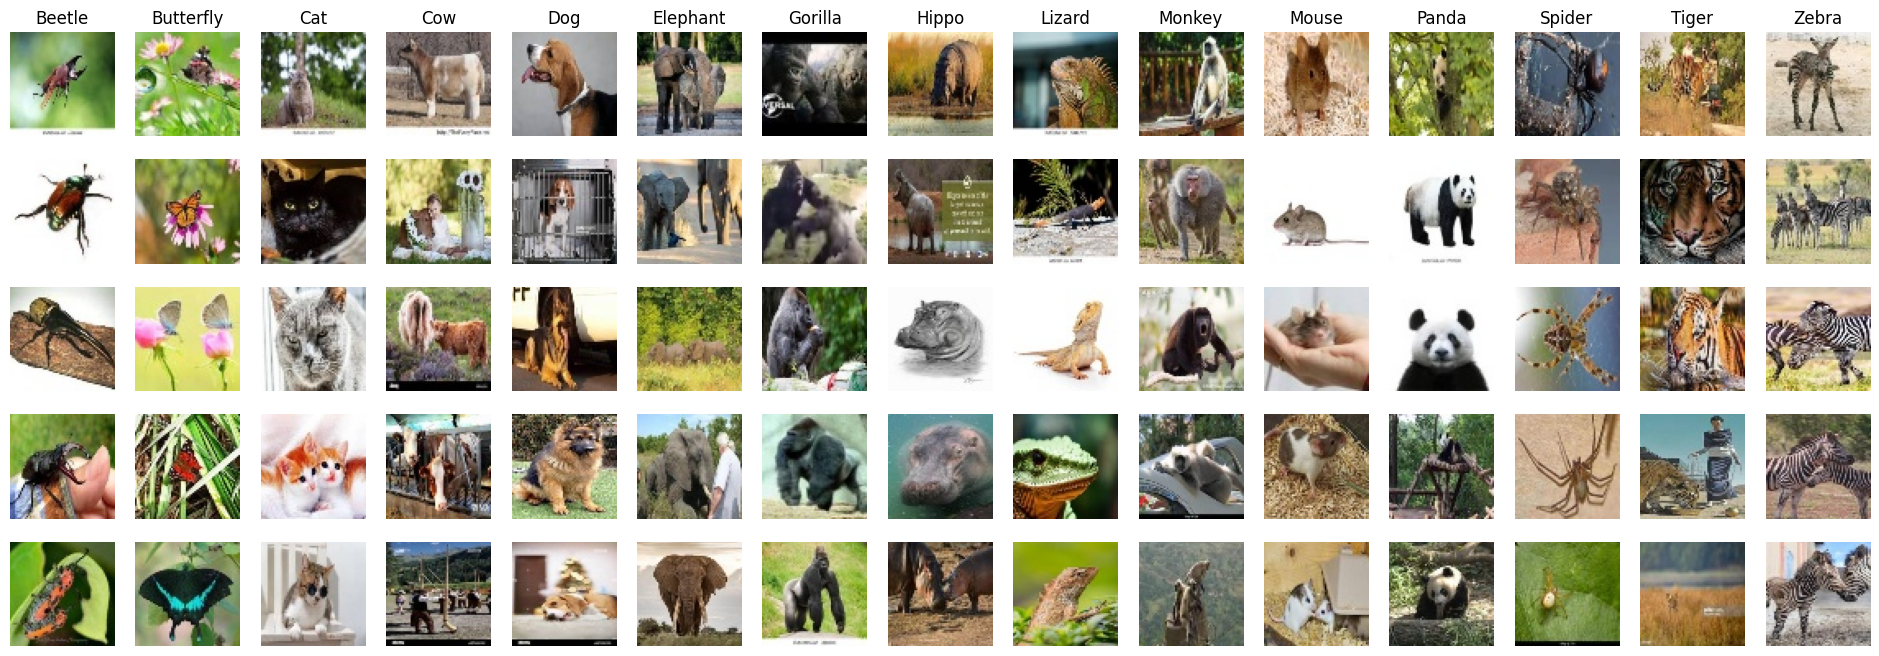

In [ ]:
import os, cv2, random
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
for i, cate in enumerate(category_list):
  img_names = random.sample(os.listdir(data_dir+'/'+cate), k=5)
  for j, img_name in enumerate(img_names): # we only show 5 images of each category
    img = plt.imread(data_dir+'/'+cate+'/'+img_name) # read the image
    plt.subplot(5, 15, 15*j+i+1) # plot the same category at the same column
    plt.imshow(img)
    plt.axis('off')
    if j == 0: # only show category name at the first row
      plt.title(cate)
plt.show()


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint

## 1. Data preprocessing


In [ ]:
# Create a dict mapping the category name to the class index
# The number of label should be 15 (0 to 14)
cate2Idx = {cate:idx for idx, cate in enumerate(category_list)}
print(cate2Idx)

{'Beetle': 0, 'Butterfly': 1, 'Cat': 2, 'Cow': 3, 'Dog': 4, 'Elephant': 5, 'Gorilla': 6, 'Hippo': 7, 'Lizard': 8, 'Monkey': 9, 'Mouse': 10, 'Panda': 11, 'Spider': 12, 'Tiger': 13, 'Zebra': 14}


In [ ]:
from tqdm import tqdm
x, y = [], []
for cate in tqdm(category_list):
  img_names = os.listdir(data_dir+'/'+cate)
  for img_name in img_names:
    img = cv2.imread(os.path.join(data_dir, cate, img_name))
    x.append(img)
    y.append(cate2Idx[cate])
x, y = np.asarray(x), np.asarray(y)

100%|██████████| 15/15 [02:10<00:00,  8.69s/it]


In [ ]:
# Check if the shapes are correct
print(x.shape)
print(y.shape)

(7500, 64, 64, 3)
(7500,)


further split the data to train and test sets with ratio 4:1 and convert the labels from integer to one-hot encoding with the following code cell.

In [ ]:
# Split the dataset to train and test parts with ratio 4:1
# x_train is a NumPy array of RGB image data with shape (6000, 64, 64, 3)
# y_train is a NumPy array of labels (in range 0-14) with shape (6000, 15)
# x_test is a NumPy array of RGB image data with shape (1500, 64, 64, 3)
# y_test is a NumPy array of labels (in range 0-14) with shape (1500, 15)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# There are 15 classes, represented as unique integers(0 to 14).
# Transform the integer into a 15-element binary vector (i.e., one-hot encoding).
y_train = to_categorical(y_train, len(category_list))
y_test = to_categorical(y_test, len(category_list))

In [ ]:
# Check if the shapes are correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6000, 64, 64, 3)
(6000, 15)
(1500, 64, 64, 3)
(1500, 15)


## 2. Data generator (augmentation)



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def get_datagen() -> ImageDataGenerator:
  datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
  return datagen

In [ ]:
datagen = get_datagen()   # Instantiate a data generator
datagen.fit(x_train)      # Fit the generator to the training data for normalization
train_generator = datagen.flow(x_train, y_train, batch_size=128) #  The generator will be used during training

## 3. Build the model



In [ ]:
# Hint: The model from the review notebook could be a good starting point.
def custom_model():
  model = Sequential(
    [Conv2D(filters=32,kernel_size=(3, 3), activation='relu', padding="same",input_shape=(64, 64, 3)),
      MaxPooling2D(pool_size=(2, 2)),
     Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding="same"),
     MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding="same"),
     MaxPooling2D(pool_size=(2, 2)),
     Conv2D(filters=256, kernel_size=(3, 3), activation='relu',padding="same"),
     MaxPooling2D(pool_size=(2, 2)),
     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding="same"),
     MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=1024, activation='relu'),
    Dense(units=1024, activation='relu'),
    Dense(units=1024, activation='relu'),
    Dropout(0.1),
    Dense(units=15, activation='softmax')]
)

  return model

# Create the model (DO NOT include this in the submission file)
model = custom_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

## 4. Compile the Model

In [ ]:
# Compile the model
# Use crossentropy loss function since there are two or more label classes
# Use adam algorithm (a stochastic gradient descent method)
# Use accuracy as metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.save('model_lab8.init.keras')

## 5. Train the model

Run the following code cell to start training.

In [ ]:
model = keras.models.load_model('model1_lab8.keras')  # Reset the model to last compilation

checkpoint_callback = ModelCheckpoint(
    filepath='model1_lab8.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)  # Save the model with the best validation accuracy seen so far at each epoch

model.fit(train_generator,
         validation_data=(x_test, y_test),
         steps_per_epoch=len(x_train) / 128, epochs=60, # By default the model is trained with 60 epochs
         callbacks=[checkpoint_callback])               # You don't have to change the number of epochs, but you may do so if it is necessary

Epoch 1/60
46/46 [==============================] - 17s 188ms/step - loss: 0.9354 - accuracy: 0.7085 - val_loss: 1.5756 - val_accuracy: 0.5760
Epoch 2/60
46/46 [==============================] - 8s 164ms/step - loss: 0.8645 - accuracy: 0.7248 - val_loss: 1.5256 - val_accuracy: 0.5833
Epoch 3/60
46/46 [==============================] - 10s 201ms/step - loss: 0.7942 - accuracy: 0.7410 - val_loss: 1.9130 - val_accuracy: 0.5107
Epoch 4/60
46/46 [==============================] - 9s 200ms/step - loss: 0.7824 - accuracy: 0.7493 - val_loss: 1.2140 - val_accuracy: 0.6353
Epoch 5/60
46/46 [==============================] - 7s 153ms/step - loss: 0.7508 - accuracy: 0.7568 - val_loss: 1.6776 - val_accuracy: 0.5620
Epoch 6/60
46/46 [==============================] - 9s 191ms/step - loss: 0.7391 - accuracy: 0.7600 - val_loss: 1.5761 - val_accuracy: 0.5787
Epoch 7/60
46/46 [==============================] - 9s 185ms/step - loss: 0.7127 - accuracy: 0.7693 - val_loss: 1.5060 - val_accuracy: 0.5880
Epoc

## 6. Evaluate the model

In [ ]:
model = keras.models.load_model('model_lab8.keras')          # Restore the best model
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)  # 'verbose=0' means no progress bar
print('Validation loss: {}'.format(val_loss))
print('Validation accuracy: {}'.format(val_acc))

Validation loss: 1.145888090133667
Validation accuracy: 0.6673333048820496


## 7. Save the model

Run the following code cell to save your model.

In [ ]:
# Save the mdoel to a keras file
model_name = 'model1_lab8.keras'              # Define model name
model.save(model_name)  # Save the model